In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import gaussian

%matplotlib inline
%load_ext rpy2.ipython

rng = np.random.RandomState(12345)

# Simulate sensor data
For this example, we'll simulate some EEG data for 10 subjects and 2 conditions. Each condition will consist of 100 
trials. We will think of each trial as presenting the subject with a word (a **noun** in trial 1, and a **verb**
in trial 2).

In [2]:
# various data parameters
fs = 1000
channels = range(32)
subjs = range(12)
conds = ['noun', 'verb']
nouns = ['time', 'year', 'people', 'way', 'day', 'man', 'thing', 'woman',
         'life', 'child', 'world', 'school', 'state', 'family', 'student',
         'group', 'country', 'problem', 'hand', 'part']
verbs = ['be', 'have', 'do', 'say', 'go', 'get', 'make', 'know', 'see', 
         'say', 'think', 'come', 'want', 'use', 'find', 'give', 'tell', 
         'work', 'call', 'try']
words = nouns + verbs
trials_per_word = 10
trials = range(len(words) * trials_per_word)
epoch_dur = 2.

In [3]:
# simulation parameters
global_intercept = 100
subj_intercepts = rng.randn(len(subjs)) * 4
cond_intercepts = np.repeat([11, 5], [len(nouns), len(verbs)])
word_intercepts = rng.randn(len(words)) * 1.5
trial_intercepts = np.tile(cond_intercepts + word_intercepts, trials_per_word)
subj_noise = np.exp(1 + rng.randn(len(subjs)))

eps = rng.randn(len(subjs), len(trials))

alpha_powers = (global_intercept + 
                subj_intercepts[:, np.newaxis] + 
                trial_intercepts[np.newaxis, :] +
                subj_noise[:, np.newaxis] * eps)

In [4]:
print((alpha_powers.min(), alpha_powers.max()))
print(alpha_powers.shape)

(68.452205204703347, 135.75969037870445)
(12, 400)


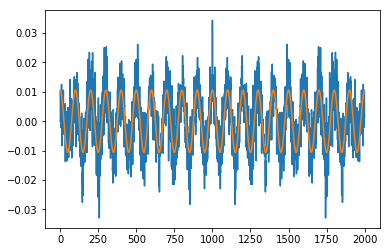

In [17]:
# generate signals with the given alpha powers
times = np.linspace(0, epoch_dur, int(epoch_dur * fs))
signals = np.empty((len(subjs), len(trials), len(times)))

fourier_freqs = np.fft.rfftfreq(len(times), d=1/fs)
alpha_freqs = np.where(np.logical_and(fourier_freqs > 8, fourier_freqs < 12))[0]
not_alpha_freqs = np.where(np.logical_or(fourier_freqs < 7, fourier_freqs > 13))[0]
fourier_coefs = np.zeros((len(subjs), len(trials), len(fourier_freqs)))
fourier_coefs[:, :, alpha_freqs[len(alpha_freqs) // 2]] = np.sqrt(alpha_powers)

signals = np.fft.irfft(fourier_coefs, axis=-1)

# make sure we didn't screw up:
powr = np.fft.rfft(signals, axis=-1)
powr = (powr * powr).sum(axis=-1)
assert np.allclose(alpha_powers, powr)

# add some energy outside alpha band
fourier_coefs[:, :, not_alpha_freqs] = rng.rand(len(not_alpha_freqs))
signal_plus_noise = np.fft.irfft(fourier_coefs, axis=-1)
signal_plus_noise[:, :, 0] = 0.  # hack to avoid cosine phase issue

plt.plot(signal_plus_noise[0,0,:])
plt.plot(signals[0,0,:])

First, we will consider the following **mixed-effects model**:

\begin{equation}
  \log y_{c,j,i} = \beta_0 + \beta_c + \beta_j + \epsilon_{c,j,i}
\end{equation}

$\epsilon_{c,j,i} \sim \mathcal{N}(0, \sigma_j)$

In [ ]:
%%R -o foo -i bar
foo <- data.frame(A=rnorm(4), B=rpois(4, 0.5))
print(bar)